In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Euler(state, param, dt, f_derivate):
    """
    state := estado actual
    params := tupla de parametros
    dt := paso de tiempo
    f_derivate := funcion que recibe el estado y los parametros y devuelve la derivada
    
    """
    dstate = f_derivate(state, param)
    return state + np.array(dstate) * dt

def defasaje(V1,V2,dt):
    V1 = V1[:]
    V2 = V2[:]

    #busco todos los defazajes cuando pasan por 0
    t_1 = []
    t_2 = []

    for i in range(1, len(V1) - 1):
        if V1[i] > 0 and V1[i-1] < 0:
            t_1.append(i)
    for i in range(1, len(V2) - 1):
        if V2[i] > 0 and V2[i-1] < 0:
            t_2.append(i)
    
    #calculo los defazajes
    return t_1, t_2

(900.0, 1000.0)

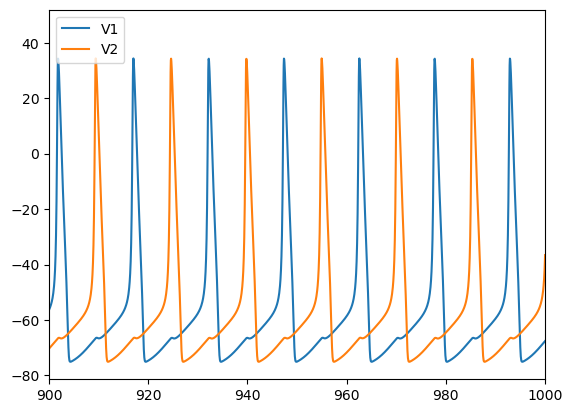

In [3]:
def Derivate_HH_conectadas(state_1, param):
    """
    state := [V, m, h, n, s] \n
    param := [V_2, I, g_syn, V_syn] \n
    
    """

    V, m, h, n , s = state_1
    V_2 = param[0]
    I = param[1]

    VNa = 50
    gNa = 120
    VK = -77
    gK = 36
    Vl = -54.4
    gl = 0.3
    C = 1

    g_syn = param[2] #0 a 2
    t_syn = 3
    V_syn = param[3]

    V = np.clip(V, -100, 100) # limito el valor de V para evitar problemas con las exponenciales

    alpha_m = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    beta_m = 4 * np.exp(-(V + 65) / 18)
    alpha_h = 0.07 * np.exp(-(V + 65) / 20)
    beta_h = 1 / (1 + np.exp(-(V + 35) / 10))
    alpha_n = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    beta_n = 0.125 * np.exp(-(V + 65) / 80)


    dV = (I - gNa * m**3 * h * (V - VNa) - gK * n**4 * (V - VK) - gl * (V - Vl) - (g_syn * s * (V-V_syn)) )/ C
    dm = alpha_m * (1 - m) - beta_m * m
    dh = alpha_h * (1 - h) - beta_h * h
    dn = alpha_n * (1 - n) - beta_n * n
    ds = (0.5 * (1 + np.tanh(V_2 - 20)) - s) / t_syn
    # ds = (0.5 * (1 + np.tanh(V_2/5)) - s) / t_syn

    return [dV, dm, dh, dn, ds]

def state(V, V2): # para condicion inicial
    a_m = 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))
    b_m = 4 * np.exp(-0.0556 * (V + 65))
    m_inf = a_m/(a_m + b_m)

    # n
    a_n = 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
    b_n = 0.125 * np.exp(-0.0125 * (V + 65))
    n_inf = a_n/(a_n + b_n)

    # h
    a_h = 0.07 * np.exp(-0.05 * (V + 65))
    b_h = 1 / (1 + np.exp(-0.1 * (V + 35)))
    h_inf = a_h/(a_h + b_h)

    #s
    s_inf = 0.5 * (1 + np.tanh(V2 - 20))
    # s_inf = 0.5 * (1 + np.tanh(V_2/5))

    return m_inf, n_inf, h_inf,  s_inf

def HodgkinHuxley(state_1_0, state_2_0, I, dt = 0.05, t_max = 2000 , g_syn = 0.5, V_syn = 0):
    state_1 = state_1_0
    state_2 = state_2_0

    out_1 = []
    out_2 = []

    t = np.arange(0, t_max, dt)

    for i in t:
        V_1_aux = state_1[0]
        V_2_aux = state_2[0]

        state_1 = Euler(state=state_1, param=(V_2_aux, I, g_syn, V_syn), dt=dt, f_derivate=Derivate_HH_conectadas)
        state_2 = Euler(state=state_2, param=(V_1_aux, I, g_syn, V_syn), dt=dt, f_derivate=Derivate_HH_conectadas)

        out_1.append(state_1)
        out_2.append(state_2)

    return np.array(out_1), np.array(out_2)


# condicion inicial
V_1 = -70
V_2 = -64
m_1, n_1, h_1, s_1 = np.array(state(V_1, V_2))*0.95
m_2, n_2, h_2, s_2 = np.array(state(V_2, V_1))*0.5

state_1_0 = [V_1, m_1, h_1, n_1, s_1]
state_2_0 = [V_2, m_2, h_2, n_2, s_2]

dt_ = 0.05
t_max_ = 1000
res = HodgkinHuxley(state_1_0, state_2_0, I=10, dt =dt_ ,t_max = t_max_, g_syn = 2, V_syn = -80)
V1 = res[0][:,0]
V2 = res[1][:,0]

x = np.linspace(0,t_max_,len(V1))

plt.plot(x, V1, label = 'V1')
plt.plot(x, V2, label = 'V2')
plt.legend()
plt.xlim(900,1000)




(900.0, 1000.0)

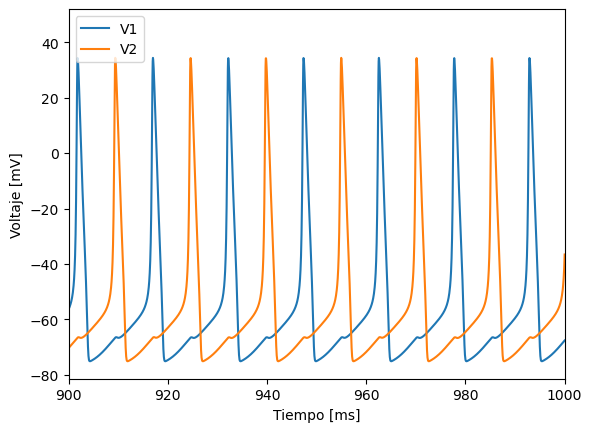

In [4]:
plt.plot(x, V1, label = 'V1')
plt.plot(x, V2, label = 'V2')
plt.legend()
plt.xlabel('Tiempo [ms]')
plt.ylabel('Voltaje [mV]')
plt.xlim(900,1000)

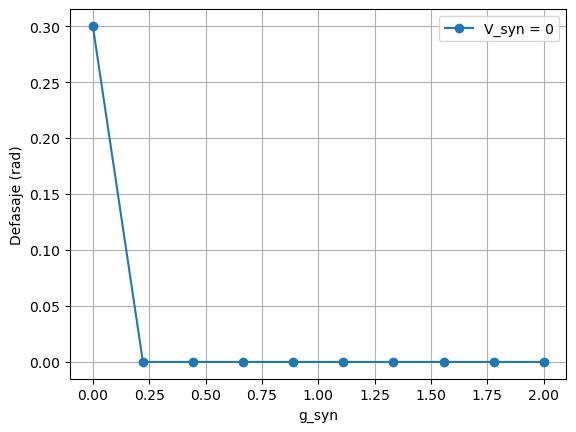

In [10]:
g_syns = np.linspace(0,2,10)

defasajes = []
periodos = []
for g_syn in g_syns:
    res = HodgkinHuxley(state_1_0, state_2_0, I=10, dt = 0.05, t_max = 1000, g_syn = g_syn)
    V1 = res[0][:,0]
    V2 = res[1][:,0]
    t_1, t_2 = defasaje(V1,V2,0.05)
    defasajes.append(t_2[-3] - t_1[-3]) 
    periodos.append(t_1[-1] - t_1[-2])

defasajes = np.abs(np.array(defasajes))
periodos = np.array(periodos)
d_norm = (defasajes / periodos) * 2 * np.pi

plt.figure()
plt.plot(g_syns,d_norm, label = 'V_syn = 0', marker = 'o')
y_ex = d_norm
y_ex_frec = 1/(periodos * dt_ *1e-3)
# y en radianes
plt.xlabel('g_syn')
plt.ylabel('Defasaje (rad)')
plt.legend()
plt.grid()


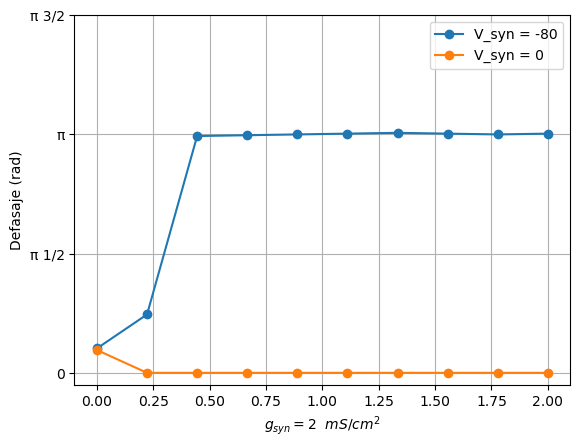

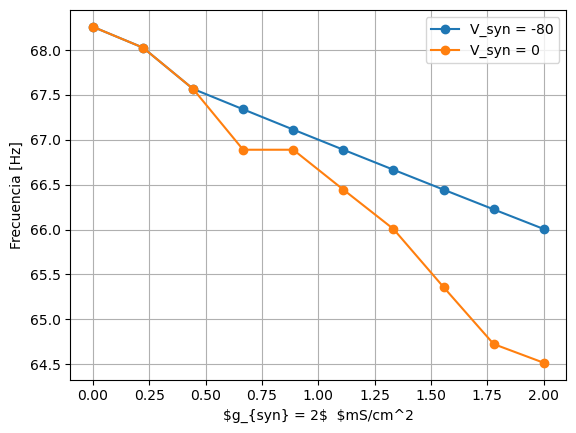

In [12]:
defasajes = []
periodos = []
for g_syn in g_syns:
    res = HodgkinHuxley(state_1_0, state_2_0, I=10, dt = 0.05, t_max = 1000, g_syn = g_syn, V_syn = -80)
    V1 = res[0][:,0]
    V2 = res[1][:,0]
    t_1, t_2 = defasaje(V1,V2,0.05)
    defasajes.append(t_2[-7] - t_1[-7]) 
    periodos.append(t_1[-4] - t_1[-5])



defasajes = np.abs(np.array(defasajes))
periodos = np.array(periodos)
d_norm = (defasajes/ periodos) * 2 * np.pi

plt.figure()
plt.plot(g_syns,d_norm, label = 'V_syn = -80', marker = 'o')
plt.plot(g_syns, y_ex, label = 'V_syn = 0', marker = 'o')

plt.xlabel(r'$g_{syn} = 2$  $mS/cm^2$')
plt.ylabel('Defasaje (rad)')
# y en 0, pi/2, pi, 3pi/2, 2pi
plt.yticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'π 1/2', 'π', 'π 3/2'])
plt.legend()
plt.grid()
plt.show()

# periodos con respecto a g_syn
plt.figure()
plt.plot(g_syns, 1/(periodos * dt_ *1e-3), label = 'V_syn = -80', marker = 'o')
plt.plot(g_syns, y_ex_frec, label = 'V_syn = 0', marker = 'o')
plt.grid()
plt.xlabel(r'$g_{syn} = 2$  $mS/cm^2')
plt.ylabel('Frecuencia [Hz]')
plt.legend()
plt.show()


In [ ]:
res = HodgkinHuxley(state_1_0, state_2_0, I=10, dt = 0.05, t_max = 1000, g_syn = 2, V_syn = 0)
V1 = res[0][:,0]
V2 = res[1][:,0]
t_1, t_2 = defasaje(V1,V2,0.05)
t_1 = np.array(t_1)
t_2 = np.array(t_2)
x = []
for i in range(len(V1)):
    x.append(i*0.05)
x = np.array(x)
plt.plot(x, V1)
plt.plot(x, V2)
plt.plot(t_1*0.05, np.zeros(len(t_1)), 'x')
plt.plot(t_2*0.05, np.zeros(len(t_2)), 'x')
plt.xlim(700,800)